# Andrew Whirisky - 17200679 and Neil Jones - 17202155

# Imports

In [10]:
import io
import csv
import pickle
import sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

# MOD Extra imports for image handling
from PIL import Image
import os
import time
import datetime
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

import Box2D
from Box2D.b2 import (edgeShape, circleShape, fixtureDef, polygonShape, revoluteJointDef, contactListener)

import gym
from gym import spaces
from gym.utils import seeding

# MLP (trained on state vectors)

In [3]:
# Rocket trajectory optimization is a classic topic in Optimal Control.
#
# According to Pontryagin's maximum principle it's optimal to fire engine full throttle or
# turn it off. That's the reason this environment is OK to have discreet actions (engine on or off).
#
# Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector.
# Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
# If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or
# comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main
# engine is -0.3 points each frame. Solved is 200 points.
#
# Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land
# on its first attempt. Please see source code for details.
#
# Too see heuristic landing, run:
#
# python gym/envs/box2d/lunar_lander_mod.py
#
# To play yourself, run:
#
# python examples/agents/keyboard_agent.py LunarLander-v0
#
# Created by Oleg Klimov. Licensed on the same terms as the rest of OpenAI Gym.

FPS    = 50
SCALE  = 30.0   # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER  = 13.0
SIDE_ENGINE_POWER  =  0.6

INITIAL_RANDOM = 1000.0   # Set 1500 to make game harder

LANDER_POLY =[
    (-14,+17), (-17,0), (-17,-10),
    (+17,-10), (+17,0), (+14,+17)
    ]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY   = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400

class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env
    def BeginContact(self, contact):
        if self.env.lander==contact.fixtureA.body or self.env.lander==contact.fixtureB.body:
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True
    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False

class LunarLander(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : FPS
    }

    continuous = False

    def __init__(self):
        self.seed()
        self.viewer = None

        self.world = Box2D.b2World()
        self.moon = None
        self.lander = None
        self.particles = []

        self.prev_reward = None

        high = np.array([np.inf]*8)  # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(-high, high)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,))
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _destroy(self):
        if not self.moon: return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])

    def reset(self):
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W/SCALE
        H = VIEWPORT_H/SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H/2, size=(CHUNKS+1,) )
        chunk_x  = [W/(CHUNKS-1)*i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS//2-1]
        self.helipad_x2 = chunk_x[CHUNKS//2+1]
        self.helipad_y  = H/4
        height[CHUNKS//2-2] = self.helipad_y
        height[CHUNKS//2-1] = self.helipad_y
        height[CHUNKS//2+0] = self.helipad_y
        height[CHUNKS//2+1] = self.helipad_y
        height[CHUNKS//2+2] = self.helipad_y
        smooth_y = [0.33*(height[i-1] + height[i+0] + height[i+1]) for i in range(CHUNKS)]

        self.moon = self.world.CreateStaticBody( shapes=edgeShape(vertices=[(0, 0), (W, 0)]) )
        self.sky_polys = []
        for i in range(CHUNKS-1):
            p1 = (chunk_x[i],   smooth_y[i])
            p2 = (chunk_x[i+1], smooth_y[i+1])
            self.moon.CreateEdgeFixture(
                vertices=[p1,p2],
                density=0,
                friction=0.1)
            self.sky_polys.append( [p1, p2, (p2[0],H), (p1[0],H)] )

        self.moon.color1 = (0.0,0.0,0.0)
        self.moon.color2 = (0.0,0.0,0.0)

        initial_y = VIEWPORT_H/SCALE
        self.lander = self.world.CreateDynamicBody(
            position = (VIEWPORT_W/SCALE/2, initial_y),
            angle=0.0,
            fixtures = fixtureDef(
                shape=polygonShape(vertices=[ (x/SCALE,y/SCALE) for x,y in LANDER_POLY ]),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0) # 0.99 bouncy
                )
        self.lander.color1 = (0.5,0.4,0.9)
        self.lander.color2 = (0.3,0.3,0.5)
        self.lander.ApplyForceToCenter( (
            self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM)
            ), True)

        self.legs = []
        for i in [-1,+1]:
            leg = self.world.CreateDynamicBody(
                position = (VIEWPORT_W/SCALE/2 - i*LEG_AWAY/SCALE, initial_y),
                angle = (i*0.05),
                fixtures = fixtureDef(
                    shape=polygonShape(box=(LEG_W/SCALE, LEG_H/SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001)
                )
            leg.ground_contact = False
            leg.color1 = (0.5,0.4,0.9)
            leg.color2 = (0.3,0.3,0.5)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i*LEG_AWAY/SCALE, LEG_DOWN/SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3*i  # low enough not to jump back into the sky
                )
            if i==-1:
                rjd.lowerAngle = +0.9 - 0.5  # Yes, the most esoteric numbers here, angles legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs

        return self.step(np.array([0,0]) if self.continuous else 0)[0]

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position = (x,y),
            angle=0.0,
            fixtures = fixtureDef(
                shape=circleShape(radius=2/SCALE, pos=(0,0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3)
                )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl<0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid " % (action,type(action))

        # Engines
        tip  = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0]);
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (not self.continuous and action==2):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0,1.0) + 1.0)*0.5   # 0.5..1.0
                assert m_power>=0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            ox =  tip[0]*(4/SCALE + 2*dispersion[0]) + side[0]*dispersion[1]   # 4 is move a bit downwards, +-2 for randomness
            oy = -tip[1]*(4/SCALE + 2*dispersion[0]) - side[1]*dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(3.5, impulse_pos[0], impulse_pos[1], m_power)    # particles are just a decoration, 3.5 is here to make particle speed adequate
            p.ApplyLinearImpulse(           ( ox*MAIN_ENGINE_POWER*m_power,  oy*MAIN_ENGINE_POWER*m_power), impulse_pos, True)
            self.lander.ApplyLinearImpulse( (-ox*MAIN_ENGINE_POWER*m_power, -oy*MAIN_ENGINE_POWER*m_power), impulse_pos, True)

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (not self.continuous and action in [1,3]):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5,1.0)
                assert s_power>=0.5 and s_power <= 1.0
            else:
                direction = action-2
                s_power = 1.0
            ox =  tip[0]*dispersion[0] + side[0]*(3*dispersion[1]+direction*SIDE_ENGINE_AWAY/SCALE)
            oy = -tip[1]*dispersion[0] - side[1]*(3*dispersion[1]+direction*SIDE_ENGINE_AWAY/SCALE)
            impulse_pos = (self.lander.position[0] + ox - tip[0]*17/SCALE, self.lander.position[1] + oy + tip[1]*SIDE_ENGINE_HEIGHT/SCALE)
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(           ( ox*SIDE_ENGINE_POWER*s_power,  oy*SIDE_ENGINE_POWER*s_power), impulse_pos, True)
            self.lander.ApplyLinearImpulse( (-ox*SIDE_ENGINE_POWER*s_power, -oy*SIDE_ENGINE_POWER*s_power), impulse_pos, True)

        self.world.Step(1.0/FPS, 6*30, 2*30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W/SCALE/2) / (VIEWPORT_W/SCALE/2),
            (pos.y - (self.helipad_y+LEG_DOWN/SCALE)) / (VIEWPORT_W/SCALE/2),
            vel.x*(VIEWPORT_W/SCALE/2)/FPS,
            vel.y*(VIEWPORT_H/SCALE/2)/FPS,
            self.lander.angle,
            20.0*self.lander.angularVelocity/FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0
            ]
        assert len(state)==8

        reward = 0
        shaping = \
            - 100*np.sqrt(state[0]*state[0] + state[1]*state[1]) \
            - 100*np.sqrt(state[2]*state[2] + state[3]*state[3]) \
            - 100*abs(state[4]) + 10*state[6] + 10*state[7]   # And ten points for legs contact, the idea is if you
                                                              # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= m_power*0.30  # less fuel spent is better, about -30 for heurisic landing
        reward -= s_power*0.03

        done = False
        if self.game_over or abs(state[0]) >= 1.0:
            done   = True
            reward = -100
        if not self.lander.awake:
            done   = True
            reward = +100
        return np.array(state), reward, done, {}

    def render(self, mode='human'):
        from gym.envs.classic_control import rendering
        if self.viewer is None:
            self.viewer = rendering.Viewer(VIEWPORT_W, VIEWPORT_H)
            self.viewer.set_bounds(0, VIEWPORT_W/SCALE, 0, VIEWPORT_H/SCALE)

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (max(0.2,0.2+obj.ttl), max(0.2,0.5*obj.ttl), max(0.2,0.5*obj.ttl))
            obj.color2 = (max(0.2,0.2+obj.ttl), max(0.2,0.5*obj.ttl), max(0.2,0.5*obj.ttl))

        self._clean_particles(False)

        for p in self.sky_polys:
            self.viewer.draw_polygon(p, color=(0,0,0))

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    t = rendering.Transform(translation=trans*f.shape.pos)
                    self.viewer.draw_circle(f.shape.radius, 20, color=obj.color1).add_attr(t)
                    self.viewer.draw_circle(f.shape.radius, 20, color=obj.color2, filled=False, linewidth=2).add_attr(t)
                else:
                    path = [trans*v for v in f.shape.vertices]
                    self.viewer.draw_polygon(path, color=obj.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj.color2, linewidth=2)

        for x in [self.helipad_x1, self.helipad_x2]:
            flagy1 = self.helipad_y
            flagy2 = flagy1 + 50/SCALE
            self.viewer.draw_polyline( [(x, flagy1), (x, flagy2)], color=(1,1,1) )
            self.viewer.draw_polygon( [(x, flagy2), (x, flagy2-10/SCALE), (x+25/SCALE, flagy2-5/SCALE)], color=(0.8,0.8,0) )

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

class LunarLanderContinuous(LunarLander):
    continuous = True

if __name__=="__main__":
    
    # Load the Lunar Lander environment
    env = LunarLander()

    total_rewards = list()

    for i in range(0, 200):

        s = env.reset()
    
        # Load and initialise the contrll model
        ROWS = 64
        COLS = 64
        CHANNELS = 1
        model = pickle.load(open("state_model.sav", "rb"))
    
        # Run the game loop
        total_reward = 0
        steps = 0
        while True:
    
            # Get the model to make a prediction
            s = np.insert(s, 0, steps)
            s = s.reshape(1, -1)
            a= model.predict(s)
            a = a[0]
    
            # Step on the game
            s, r, done, info = env.step(a)
            env.render()
            total_reward += r
            if steps % 20 == 0 or done:
                print(["{:+0.2f}".format(x) for x in s])
                print("step {} total_reward {:+0.2f}".format(steps, total_reward))
            steps += 1
        
                    
            if done: 
                total_rewards.append(total_reward)
                break

print("total rewards", total_rewards)
print("average total reward", np.mean(total_rewards))

# Write total rewards to file
f = open("lunarlander_ml_states_rewards.csv",'w')
wr = csv.writer(f)
for r in total_rewards:
     wr.writerow([r,])
f.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
['-0.00', '+0.93', '-0.09', '-0.22', '-0.00', '-0.02', '+0.00', '+0.00']
step 0 total_reward -1.44
['-0.02', '+0.78', '-0.09', '-0.75', '-0.02', '-0.02', '+0.00', '+0.00']
step 20 total_reward -41.07
['-0.03', '+0.56', '-0.04', '-0.64', '-0.04', '-0.01', '+0.00', '+0.00']
step 40 total_reward -12.56
['-0.04', '+0.39', '+0.01', '-0.51', '-0.07', '-0.01', '+0.00', '+0.00']
step 60 total_reward +10.88
['-0.04', '+0.27', '-0.01', '-0.31', '-0.11', '-0.03', '+0.00', '+0.00']
step 80 total_reward +33.76
['-0.04', '+0.18', '+0.13', '-0.28', '-0.09', '+0.07', '+0.00', '+0.00']
step 100 total_reward +40.97
['-0.01', '+0.11', '+0.11', '-0.21', '-0.06', '-0.01', '+0.00', '+0.00']
step 120 total_reward +55.24
['+0.01', '+0.06', '+0.14', '-0.13', '-0.06', '+0.01', '+0.00', '+0.00']
step 140 total_reward +60.54
['+0.05', '+0.03', '+0.25', '-0.09', '-0.03', '+0.07', '+0.00', '+0.00']
step 160 total_rewa

['-0.07', '+0.05', '-0.03', '-0.13', '-0.17', '-0.01', '+0.00', '+0.00']
step 160 total_reward +47.17
['-0.06', '+0.02', '+0.14', '-0.06', '-0.14', '+0.06', '+0.00', '+0.00']
step 180 total_reward +46.10
['-0.02', '-0.00', '+0.15', '+0.02', '+0.01', '-0.08', '+1.00', '+1.00']
step 200 total_reward +81.14
['-0.00', '-0.00', '+0.04', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 220 total_reward +94.34
['-0.00', '-0.00', '+0.00', '+0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 240 total_reward +98.42
['-0.00', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 251 total_reward +198.42
['-0.01', '+0.95', '-0.28', '+0.28', '+0.01', '+0.03', '+0.00', '+0.00']
step 0 total_reward +1.77
['-0.06', '+0.95', '-0.25', '-0.26', '-0.07', '-0.08', '+0.00', '+0.00']
step 20 total_reward -1.93
['-0.11', '+0.79', '-0.25', '-0.79', '-0.16', '-0.08', '+0.00', '+0.00']
step 40 total_reward -41.78
['-0.15', '+0.57', '-0.09', '-0.60', '-0.24', '-0.05', '+0.00', '+0.00']
step 60 total_

['+0.19', '+0.05', '+0.16', '-0.05', '+0.13', '+0.07', '+0.00', '+0.00']
step 180 total_reward +20.23
['+0.20', '+0.04', '-0.06', '-0.03', '+0.15', '-0.03', '+0.00', '+0.00']
step 200 total_reward +24.03
['+0.18', '+0.03', '-0.15', '-0.02', '+0.15', '+0.00', '+0.00', '+0.00']
step 220 total_reward +13.27
['+0.14', '+0.03', '-0.22', '-0.03', '+0.14', '+0.00', '+0.00', '+0.00']
step 240 total_reward +7.40
['+0.08', '+0.02', '-0.28', '-0.02', '+0.09', '-0.02', '+0.00', '+0.00']
step 260 total_reward +8.46
['+0.03', '-0.00', '-0.26', '-0.08', '-0.01', '-0.27', '+1.00', '+1.00']
step 280 total_reward +40.61
['-0.01', '-0.00', '-0.13', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 300 total_reward +57.49
['-0.02', '-0.00', '-0.02', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 320 total_reward +67.40
['-0.02', '-0.00', '-0.00', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 340 total_reward +69.06
['-0.02', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 347 to

['+0.09', '+0.78', '+0.38', '-0.78', '+0.12', '+0.15', '+0.00', '+0.00']
step 20 total_reward -33.50
['+0.15', '+0.56', '+0.19', '-0.59', '+0.26', '+0.08', '+0.00', '+0.00']
step 40 total_reward -7.52
['+0.16', '+0.40', '-0.09', '-0.46', '+0.27', '-0.01', '+0.00', '+0.00']
step 60 total_reward +15.68
['+0.12', '+0.29', '-0.26', '-0.32', '+0.20', '-0.12', '+0.00', '+0.00']
step 80 total_reward +36.30
['+0.05', '+0.20', '-0.39', '-0.27', '+0.07', '-0.12', '+0.00', '+0.00']
step 100 total_reward +50.15
['-0.02', '+0.13', '-0.37', '-0.22', '-0.03', '-0.09', '+0.00', '+0.00']
step 120 total_reward +62.48
['-0.09', '+0.08', '-0.33', '-0.12', '-0.12', '-0.11', '+0.00', '+0.00']
step 140 total_reward +58.61
['-0.15', '+0.05', '-0.24', '-0.08', '-0.22', '-0.07', '+0.00', '+0.00']
step 160 total_reward +50.43
['-0.18', '+0.04', '-0.05', '-0.03', '-0.24', '+0.01', '+0.00', '+0.00']
step 180 total_reward +62.45
['-0.17', '+0.03', '+0.13', '-0.04', '-0.20', '+0.06', '+0.00', '+0.00']
step 200 total

['+0.05', '+0.43', '-0.07', '-0.46', '+0.09', '-0.03', '+0.00', '+0.00']
step 60 total_reward +3.73
['+0.02', '+0.30', '-0.17', '-0.39', '+0.05', '-0.07', '+0.00', '+0.00']
step 80 total_reward +21.14
['-0.01', '+0.20', '-0.17', '-0.27', '-0.02', '-0.05', '+0.00', '+0.00']
step 100 total_reward +41.41
['-0.05', '+0.12', '-0.18', '-0.21', '-0.09', '-0.09', '+0.00', '+0.00']
step 120 total_reward +41.08
['-0.08', '+0.08', '-0.08', '-0.10', '-0.15', '-0.06', '+0.00', '+0.00']
step 140 total_reward +47.94
['-0.08', '+0.04', '+0.03', '-0.09', '-0.17', '-0.00', '+0.00', '+0.00']
step 160 total_reward +47.52
['-0.06', '+0.02', '+0.16', '-0.08', '-0.09', '+0.06', '+0.00', '+0.00']
step 180 total_reward +46.53
['-0.03', '-0.00', '+0.10', '+0.01', '+0.03', '-0.03', '+1.00', '+1.00']
step 200 total_reward +81.42
['-0.02', '-0.00', '-0.00', '-0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 220 total_reward +94.99
['-0.02', '-0.00', '-0.00', '-0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 240 tot

['+0.22', '+0.63', '+0.11', '-0.65', '+0.33', '+0.03', '+0.00', '+0.00']
step 60 total_reward -15.51
['+0.21', '+0.46', '-0.17', '-0.51', '+0.30', '-0.06', '+0.00', '+0.00']
step 80 total_reward +11.48
['+0.15', '+0.33', '-0.38', '-0.32', '+0.17', '-0.19', '+0.00', '+0.00']
step 100 total_reward +36.68
['+0.07', '+0.24', '-0.44', '-0.29', '-0.02', '-0.18', '+0.00', '+0.00']
step 120 total_reward +57.37
['-0.01', '+0.16', '-0.29', '-0.23', '-0.16', '-0.12', '+0.00', '+0.00']
step 140 total_reward +64.08
['-0.05', '+0.09', '-0.10', '-0.18', '-0.20', '+0.00', '+0.00', '+0.00']
step 160 total_reward +77.51
['-0.05', '+0.05', '+0.06', '-0.09', '-0.19', '+0.06', '+0.00', '+0.00']
step 180 total_reward +88.51
['-0.03', '+0.02', '+0.13', '-0.12', '-0.14', '+0.06', '+0.00', '+0.00']
step 200 total_reward +86.60
['+0.01', '-0.00', '+0.17', '-0.00', '+0.03', '+0.00', '+1.00', '+1.00']
step 220 total_reward +118.57
['+0.03', '-0.00', '+0.05', '-0.00', '+0.00', '-0.00', '+1.00', '+1.00']
step 240 t

['-0.10', '+0.16', '+0.06', '-0.21', '-0.16', '+0.02', '+0.00', '+0.00']
step 120 total_reward +33.67
['-0.07', '+0.11', '+0.17', '-0.15', '-0.10', '+0.05', '+0.00', '+0.00']
step 140 total_reward +41.00
['-0.03', '+0.06', '+0.20', '-0.14', '-0.07', '+0.03', '+0.00', '+0.00']
step 160 total_reward +43.96
['+0.01', '+0.02', '+0.21', '-0.10', '-0.01', '+0.06', '+0.00', '+0.00']
step 180 total_reward +51.65
['+0.05', '+0.00', '+0.22', '-0.04', '+0.05', '-0.15', '+0.00', '+1.00']
step 200 total_reward +51.76
['+0.09', '-0.00', '+0.11', '+0.01', '-0.00', '+0.03', '+1.00', '+1.00']
step 220 total_reward +74.49
['+0.10', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+0.00']
step 240 total_reward +74.57
['+0.10', '-0.00', '-0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+0.00']
step 260 total_reward +74.61
['+0.10', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+0.00']
step 264 total_reward +174.61
['+0.01', '+0.93', '+0.25', '-0.27', '-0.00', '-0.03', '+0.00', '+0.00']
step 0 t

['+0.33', '+0.41', '+0.16', '-0.36', '+0.37', '+0.03', '+0.00', '+0.00']
step 60 total_reward +42.47
['+0.32', '+0.32', '-0.14', '-0.25', '+0.32', '-0.11', '+0.00', '+0.00']
step 80 total_reward +60.80
['+0.26', '+0.25', '-0.39', '-0.18', '+0.18', '-0.16', '+0.00', '+0.00']
step 100 total_reward +65.96
['+0.18', '+0.20', '-0.48', '-0.19', '+0.02', '-0.17', '+0.00', '+0.00']
step 120 total_reward +80.23
['+0.09', '+0.14', '-0.39', '-0.16', '-0.14', '-0.13', '+0.00', '+0.00']
step 140 total_reward +84.37
['+0.03', '+0.09', '-0.16', '-0.19', '-0.22', '-0.01', '+0.00', '+0.00']
step 160 total_reward +96.19
['+0.03', '+0.04', '+0.10', '-0.10', '-0.19', '+0.05', '+0.00', '+0.00']
step 180 total_reward +109.87
['+0.06', '+0.02', '+0.19', '-0.05', '-0.13', '+0.07', '+0.00', '+0.00']
step 200 total_reward +105.58
['+0.11', '+0.00', '+0.28', '-0.04', '+0.01', '-0.14', '+0.00', '+1.00']
step 220 total_reward +110.52
['+0.16', '-0.01', '+0.24', '-0.02', '-0.07', '-0.07', '+1.00', '+1.00']
step 240

['-0.07', '+0.14', '+0.39', '-0.21', '+0.01', '+0.05', '+0.00', '+0.00']
step 140 total_reward +81.30
['+0.01', '+0.08', '+0.39', '-0.18', '+0.07', '+0.09', '+0.00', '+0.00']
step 160 total_reward +79.90
['+0.08', '+0.05', '+0.28', '-0.08', '+0.17', '+0.09', '+0.00', '+0.00']
step 180 total_reward +79.44
['+0.11', '+0.03', '+0.10', '-0.07', '+0.25', '+0.02', '+0.00', '+0.00']
step 200 total_reward +83.09
['+0.10', '+0.01', '-0.13', '-0.07', '+0.12', '-0.37', '+0.00', '+0.00']
step 220 total_reward +89.91
['+0.08', '-0.00', '-0.11', '-0.00', '-0.00', '+0.00', '+1.00', '+0.00']
step 240 total_reward +117.62
['+0.07', '-0.00', '+0.00', '+0.00', '-0.00', '-0.00', '+1.00', '+0.00']
step 260 total_reward +129.34
['+0.07', '-0.00', '+0.00', '-0.00', '-0.00', '-0.00', '+1.00', '+0.00']
step 280 total_reward +129.48
['+0.07', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+0.00']
step 283 total_reward +229.48
['+0.01', '+0.94', '+0.51', '+0.09', '-0.01', '-0.07', '+0.00', '+0.00']
step 

['-0.08', '+0.27', '+0.25', '-0.33', '-0.07', '+0.11', '+0.00', '+0.00']
step 80 total_reward +51.56
['-0.02', '+0.18', '+0.29', '-0.24', '+0.05', '+0.13', '+0.00', '+0.00']
step 100 total_reward +64.09
['+0.04', '+0.11', '+0.22', '-0.21', '+0.16', '+0.10', '+0.00', '+0.00']
step 120 total_reward +63.03
['+0.07', '+0.07', '+0.08', '-0.09', '+0.20', '+0.03', '+0.00', '+0.00']
step 140 total_reward +75.13
['+0.06', '+0.04', '-0.11', '-0.11', '+0.17', '-0.05', '+0.00', '+0.00']
step 160 total_reward +74.90
['+0.03', '+0.01', '-0.17', '-0.08', '+0.11', '-0.06', '+0.00', '+0.00']
step 180 total_reward +77.49
['-0.01', '-0.00', '-0.16', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 200 total_reward +111.83
['-0.03', '-0.00', '-0.05', '+0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 220 total_reward +121.14
['-0.03', '-0.00', '-0.00', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 240 total_reward +125.64
['-0.03', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 25

['+0.01', '-0.00', '-0.00', '+0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 260 total_reward +131.24
['+0.01', '-0.00', '-0.00', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 280 total_reward +131.45
['+0.01', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 285 total_reward +231.45
['-0.00', '+0.95', '-0.04', '+0.40', '+0.00', '+0.01', '+0.00', '+0.00']
step 0 total_reward +1.92
['-0.01', '+0.99', '-0.04', '-0.13', '+0.01', '+0.01', '+0.00', '+0.00']
step 20 total_reward +23.58
['-0.02', '+0.86', '-0.04', '-0.67', '+0.02', '+0.01', '+0.00', '+0.00']
step 40 total_reward -17.82
['-0.02', '+0.63', '-0.06', '-0.73', '+0.03', '-0.00', '+0.00', '+0.00']
step 60 total_reward -4.39
['-0.04', '+0.44', '-0.10', '-0.51', '+0.04', '+0.00', '+0.00', '+0.00']
step 80 total_reward +28.74
['-0.06', '+0.31', '-0.11', '-0.34', '+0.04', '-0.02', '+0.00', '+0.00']
step 100 total_reward +53.54
['-0.09', '+0.21', '-0.18', '-0.23', '-0.01', '-0.06', '+0.00', '+0.00']
step 120 total

['+0.22', '+0.02', '+0.08', '+0.03', '+0.14', '+0.06', '+0.00', '+0.00']
step 240 total_reward +27.98
['+0.22', '+0.03', '-0.08', '+0.03', '+0.17', '+0.03', '+0.00', '+0.00']
step 260 total_reward +21.05
['+0.19', '+0.03', '-0.26', '-0.00', '+0.18', '-0.02', '+0.00', '+0.00']
step 280 total_reward +1.82
['+0.12', '+0.03', '-0.41', '-0.03', '+0.16', '-0.04', '+0.00', '+0.00']
step 300 total_reward -7.95
['+0.03', '+0.01', '-0.47', '-0.09', '+0.09', '-0.10', '+0.00', '+0.00']
step 320 total_reward -2.35
['-0.07', '-0.00', '-0.44', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 340 total_reward +24.87
['-0.15', '+0.00', '-0.31', '+0.01', '-0.02', '-0.03', '+0.00', '+0.00']
step 360 total_reward +9.15
['-0.19', '+0.00', '-0.18', '+0.03', '-0.04', '-0.03', '+0.00', '+0.00']
step 380 total_reward +14.22
['-0.23', '+0.01', '-0.18', '+0.02', '-0.08', '-0.07', '+0.00', '+0.00']
step 400 total_reward +4.12
['-0.26', '+0.02', '-0.09', '+0.04', '-0.16', '-0.08', '+0.00', '+0.00']
step 420 total

['+0.01', '+0.08', '+0.18', '-0.16', '+0.18', '+0.02', '+0.00', '+0.00']
step 140 total_reward +72.69
['+0.04', '+0.04', '+0.09', '-0.13', '+0.20', '-0.01', '+0.00', '+0.00']
step 160 total_reward +77.80
['+0.03', '+0.01', '-0.15', '-0.07', '+0.13', '-0.27', '+0.00', '+1.00']
step 180 total_reward +93.30
['-0.00', '-0.00', '-0.09', '+0.01', '-0.02', '+0.04', '+1.00', '+1.00']
step 200 total_reward +123.23
['-0.01', '-0.00', '-0.00', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 220 total_reward +133.13
['-0.01', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 240 total_reward +233.15
['-0.01', '+0.92', '-0.44', '-0.55', '+0.01', '+0.05', '+0.00', '+0.00']
step 0 total_reward -0.67
['-0.09', '+0.70', '-0.37', '-0.77', '-0.14', '-0.19', '+0.00', '+0.00']
step 20 total_reward -8.43
['-0.14', '+0.50', '-0.14', '-0.57', '-0.28', '-0.04', '+0.00', '+0.00']
step 40 total_reward +16.68
['-0.14', '+0.36', '+0.12', '-0.39', '-0.25', '+0.11', '+0.00', '+0.00']
step 60 tota

['-0.06', '-0.00', '-0.05', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 260 total_reward +111.73
['-0.06', '-0.00', '-0.00', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 280 total_reward +116.61
['-0.06', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 293 total_reward +216.61
['+0.01', '+0.93', '+0.47', '-0.39', '-0.01', '-0.08', '+0.00', '+0.00']
step 0 total_reward -0.80
['+0.09', '+0.73', '+0.39', '-0.82', '+0.11', '+0.14', '+0.00', '+0.00']
step 20 total_reward -22.01
['+0.15', '+0.53', '+0.16', '-0.56', '+0.21', '+0.02', '+0.00', '+0.00']
step 40 total_reward +12.53
['+0.17', '+0.39', '-0.04', '-0.41', '+0.21', '-0.07', '+0.00', '+0.00']
step 60 total_reward +38.56
['+0.13', '+0.29', '-0.22', '-0.31', '+0.13', '-0.08', '+0.00', '+0.00']
step 80 total_reward +57.46
['+0.07', '+0.20', '-0.34', '-0.24', '+0.01', '-0.13', '+0.00', '+0.00']
step 100 total_reward +71.41
['+0.01', '+0.13', '-0.29', '-0.24', '-0.10', '-0.12', '+0.00', '+0.00']
step 120 tota

['+0.03', '+0.11', '-0.31', '-0.19', '-0.02', '-0.07', '+0.00', '+0.00']
step 140 total_reward +73.05
['-0.02', '+0.06', '-0.22', '-0.16', '-0.06', '-0.03', '+0.00', '+0.00']
step 160 total_reward +78.68
['-0.07', '+0.03', '-0.21', '-0.09', '-0.11', '-0.08', '+0.00', '+0.00']
step 180 total_reward +74.81
['-0.10', '+0.00', '-0.13', '-0.12', '-0.04', '+0.39', '+0.00', '+0.00']
step 200 total_reward +81.12
['-0.10', '-0.00', '+0.00', '+0.00', '+0.00', '-0.00', '+1.00', '+1.00']
step 220 total_reward +121.18
['-0.10', '-0.00', '+0.00', '+0.00', '+0.00', '-0.00', '+1.00', '+1.00']
step 240 total_reward +121.28
['-0.10', '-0.00', '+0.00', '+0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 242 total_reward +221.28
['+0.01', '+0.92', '+0.71', '-0.54', '-0.01', '-0.12', '+0.00', '+0.00']
step 0 total_reward -0.34
['+0.15', '+0.70', '+0.67', '-0.77', '+0.12', '+0.22', '+0.00', '+0.00']
step 20 total_reward -5.11
['+0.26', '+0.52', '+0.49', '-0.52', '+0.33', '+0.15', '+0.00', '+0.00']
step 40 tot

['+0.14', '+0.10', '+0.02', '-0.11', '+0.20', '-0.02', '+0.00', '+0.00']
step 160 total_reward +67.96
['+0.12', '+0.07', '-0.20', '-0.06', '+0.16', '-0.08', '+0.00', '+0.00']
step 180 total_reward +62.17
['+0.07', '+0.05', '-0.32', '-0.11', '+0.07', '-0.11', '+0.00', '+0.00']
step 200 total_reward +61.48
['+0.00', '+0.02', '-0.34', '-0.12', '-0.04', '-0.12', '+0.00', '+0.00']
step 220 total_reward +64.65
['-0.05', '-0.00', '-0.25', '-0.01', '+0.01', '-0.08', '+1.00', '+1.00']
step 240 total_reward +93.21
['-0.09', '-0.00', '-0.13', '-0.00', '+0.00', '+0.00', '+0.00', '+1.00']
step 260 total_reward +91.56
['-0.10', '-0.00', '-0.02', '+0.00', '+0.00', '+0.00', '+0.00', '+1.00']
step 280 total_reward +101.48
['-0.10', '-0.00', '-0.00', '-0.00', '+0.00', '+0.00', '+0.00', '+1.00']
step 300 total_reward +103.07
['-0.10', '-0.00', '+0.00', '+0.00', '+0.00', '+0.00', '+0.00', '+1.00']
step 307 total_reward +203.07
['+0.01', '+0.93', '+0.49', '-0.35', '-0.01', '-0.07', '+0.00', '+0.00']
step 0

['+0.25', '+0.54', '+0.06', '-0.53', '+0.35', '-0.06', '+0.00', '+0.00']
step 60 total_reward -1.02
['+0.23', '+0.41', '-0.21', '-0.40', '+0.25', '-0.15', '+0.00', '+0.00']
step 80 total_reward +26.08
['+0.16', '+0.31', '-0.36', '-0.31', '+0.08', '-0.14', '+0.00', '+0.00']
step 100 total_reward +48.67
['+0.08', '+0.22', '-0.39', '-0.28', '-0.05', '-0.15', '+0.00', '+0.00']
step 120 total_reward +59.37
['+0.01', '+0.15', '-0.34', '-0.26', '-0.18', '-0.08', '+0.00', '+0.00']
step 140 total_reward +57.41
['-0.04', '+0.09', '-0.15', '-0.15', '-0.24', '+0.00', '+0.00', '+0.00']
step 160 total_reward +73.76
['-0.04', '+0.05', '+0.06', '-0.14', '-0.19', '+0.08', '+0.00', '+0.00']
step 180 total_reward +83.88
['-0.01', '+0.01', '+0.18', '-0.09', '-0.11', '+0.06', '+0.00', '+0.00']
step 200 total_reward +88.62
['+0.03', '-0.00', '+0.12', '+0.05', '-0.00', '+0.15', '+1.00', '+1.00']
step 220 total_reward +123.67
['+0.04', '-0.00', '+0.02', '-0.00', '+0.00', '-0.00', '+1.00', '+1.00']
step 240 to

['+0.14', '+0.18', '-0.43', '-0.19', '+0.03', '-0.13', '+0.00', '+0.00']
step 120 total_reward +83.75
['+0.06', '+0.12', '-0.39', '-0.19', '-0.08', '-0.11', '+0.00', '+0.00']
step 140 total_reward +88.65
['-0.01', '+0.07', '-0.28', '-0.17', '-0.18', '-0.07', '+0.00', '+0.00']
step 160 total_reward +90.07
['-0.05', '+0.03', '-0.13', '-0.12', '-0.21', '+0.02', '+0.00', '+0.00']
step 180 total_reward +100.66
['-0.05', '+0.00', '-0.02', '-0.11', '-0.03', '+0.40', '+0.00', '+0.00']
step 200 total_reward +122.20
['-0.05', '-0.00', '+0.01', '+0.01', '+0.01', '-0.05', '+1.00', '+1.00']
step 220 total_reward +153.94
['-0.05', '-0.00', '-0.00', '+0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 240 total_reward +156.20
['-0.05', '-0.00', '+0.00', '+0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 248 total_reward +256.20
['+0.01', '+0.94', '+0.35', '+0.01', '-0.01', '-0.03', '+0.00', '+0.00']
step 0 total_reward +1.14
['+0.07', '+0.86', '+0.31', '-0.52', '+0.11', '+0.12', '+0.00', '+0.00']
step 20

['-0.25', '+0.47', '+0.16', '-0.50', '-0.36', '+0.06', '+0.00', '+0.00']
step 80 total_reward +9.54
['-0.18', '+0.35', '+0.48', '-0.36', '-0.20', '+0.21', '+0.00', '+0.00']
step 100 total_reward +28.01
['-0.07', '+0.25', '+0.56', '-0.31', '-0.00', '+0.20', '+0.00', '+0.00']
step 120 total_reward +52.52
['+0.04', '+0.17', '+0.47', '-0.22', '+0.20', '+0.15', '+0.00', '+0.00']
step 140 total_reward +50.37
['+0.13', '+0.11', '+0.32', '-0.15', '+0.31', '+0.04', '+0.00', '+0.00']
step 160 total_reward +52.07
['+0.16', '+0.08', '+0.09', '-0.11', '+0.32', '-0.07', '+0.00', '+0.00']
step 180 total_reward +67.03
['+0.15', '+0.06', '-0.17', '-0.04', '+0.24', '-0.11', '+0.00', '+0.00']
step 200 total_reward +69.15
['+0.11', '+0.04', '-0.31', '-0.07', '+0.14', '-0.11', '+0.00', '+0.00']
step 220 total_reward +67.28
['+0.03', '+0.02', '-0.37', '-0.10', '+0.02', '-0.10', '+0.00', '+0.00']
step 240 total_reward +76.95
['-0.04', '-0.00', '-0.36', '-0.11', '+0.01', '+0.23', '+0.00', '+1.00']
step 260 to

['-0.10', '+0.19', '+0.20', '-0.21', '-0.13', '+0.09', '+0.00', '+0.00']
step 100 total_reward +59.48
['-0.05', '+0.12', '+0.27', '-0.20', '-0.06', '+0.07', '+0.00', '+0.00']
step 120 total_reward +66.34
['+0.00', '+0.07', '+0.26', '-0.19', '-0.01', '+0.04', '+0.00', '+0.00']
step 140 total_reward +76.72
['+0.04', '+0.03', '+0.20', '-0.11', '+0.01', '+0.04', '+0.00', '+0.00']
step 160 total_reward +82.45
['+0.09', '+0.01', '+0.20', '-0.04', '+0.07', '+0.08', '+0.00', '+0.00']
step 180 total_reward +71.01
['+0.11', '-0.00', '+0.04', '+0.02', '-0.03', '-0.09', '+1.00', '+1.00']
step 200 total_reward +107.02
['+0.11', '-0.00', '-0.00', '-0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 220 total_reward +114.23
['+0.11', '-0.00', '+0.00', '+0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 237 total_reward +214.23
['+0.00', '+0.93', '+0.19', '-0.50', '-0.00', '+0.00', '+0.00', '+0.00']
step 0 total_reward -1.19
['+0.04', '+0.70', '+0.13', '-0.81', '+0.07', '+0.06', '+0.00', '+0.00']
step 20 t

['+0.02', '-0.00', '+0.07', '+0.01', '+0.02', '-0.05', '+1.00', '+1.00']
step 220 total_reward +130.06
['+0.02', '-0.00', '-0.00', '-0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 240 total_reward +138.80
['+0.02', '-0.00', '+0.00', '+0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 257 total_reward +238.80
['+0.01', '+0.93', '+0.41', '-0.35', '-0.01', '-0.05', '+0.00', '+0.00']
step 0 total_reward -0.51
['+0.08', '+0.74', '+0.33', '-0.80', '+0.14', '+0.16', '+0.00', '+0.00']
step 20 total_reward -28.95
['+0.13', '+0.53', '+0.15', '-0.61', '+0.26', '+0.06', '+0.00', '+0.00']
step 40 total_reward -1.63
['+0.13', '+0.38', '-0.10', '-0.42', '+0.24', '-0.07', '+0.00', '+0.00']
step 60 total_reward +28.16
['+0.09', '+0.28', '-0.24', '-0.34', '+0.15', '-0.09', '+0.00', '+0.00']
step 80 total_reward +47.41
['+0.03', '+0.19', '-0.34', '-0.28', '+0.05', '-0.10', '+0.00', '+0.00']
step 100 total_reward +61.96
['-0.04', '+0.12', '-0.31', '-0.20', '-0.05', '-0.07', '+0.00', '+0.00']
step 120 total

step 280 total_reward +121.45
['-0.06', '-0.00', '-0.03', '+0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 300 total_reward +131.05
['-0.06', '-0.00', '+0.00', '+0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 320 total_reward +134.20
['-0.06', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 330 total_reward +234.20
['-0.01', '+0.93', '-0.45', '-0.53', '+0.01', '+0.06', '+0.00', '+0.00']
step 0 total_reward -0.73
['-0.09', '+0.70', '-0.39', '-0.77', '-0.13', '-0.16', '+0.00', '+0.00']
step 20 total_reward -10.09
['-0.16', '+0.51', '-0.28', '-0.55', '-0.26', '-0.09', '+0.00', '+0.00']
step 40 total_reward +14.33
['-0.18', '+0.37', '-0.01', '-0.40', '-0.28', '+0.09', '+0.00', '+0.00']
step 60 total_reward +41.09
['-0.16', '+0.27', '+0.18', '-0.30', '-0.19', '+0.10', '+0.00', '+0.00']
step 80 total_reward +61.40
['-0.10', '+0.19', '+0.36', '-0.23', '-0.07', '+0.15', '+0.00', '+0.00']
step 100 total_reward +70.49
['-0.03', '+0.13', '+0.32', '-0.22', '+0.06', '+0.11', '

['-0.54', '-0.07', '+0.15', '-0.03', '-0.19', '+0.04', '+1.00', '+1.00']
step 400 total_reward +6.22
['-0.51', '-0.08', '+0.23', '-0.04', '-0.14', '+0.06', '+1.00', '+1.00']
step 420 total_reward +7.15
['-0.46', '-0.08', '+0.14', '+0.02', '-0.04', '+0.10', '+1.00', '+1.00']
step 440 total_reward +30.00
['-0.45', '-0.08', '+0.00', '+0.00', '-0.02', '+0.00', '+1.00', '+1.00']
step 460 total_reward +46.56
['-0.45', '-0.08', '+0.00', '+0.00', '-0.02', '+0.00', '+1.00', '+1.00']
step 480 total_reward +146.56
['+0.00', '+0.94', '+0.11', '-0.14', '-0.00', '+0.01', '+0.00', '+0.00']
step 0 total_reward -1.19
['+0.02', '+0.81', '+0.10', '-0.67', '+0.04', '+0.04', '+0.00', '+0.00']
step 20 total_reward -43.14
['+0.04', '+0.59', '+0.02', '-0.69', '+0.08', '+0.02', '+0.00', '+0.00']
step 40 total_reward -29.40
['+0.02', '+0.41', '-0.12', '-0.46', '+0.05', '-0.04', '+0.00', '+0.00']
step 60 total_reward +7.13
['+0.00', '+0.28', '-0.11', '-0.40', '+0.04', '+0.01', '+0.00', '+0.00']
step 80 total_rew

['-0.02', '-0.00', '+0.27', '-0.08', '+0.01', '+0.42', '+1.00', '+1.00']
step 200 total_reward +91.79
['+0.02', '-0.00', '+0.14', '-0.00', '+0.00', '-0.00', '+1.00', '+1.00']
step 220 total_reward +107.24
['+0.03', '-0.00', '+0.03', '-0.00', '+0.00', '-0.00', '+1.00', '+1.00']
step 240 total_reward +116.87
['+0.04', '-0.00', '-0.00', '-0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 260 total_reward +119.82
['+0.04', '-0.00', '+0.00', '+0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 269 total_reward +219.82
['+0.01', '+0.95', '+0.73', '+0.44', '-0.01', '-0.13', '+0.00', '+0.00']
step 0 total_reward +0.95
['+0.15', '+1.00', '+0.65', '-0.09', '+0.11', '+0.18', '+0.00', '+0.00']
step 20 total_reward +4.51
['+0.28', '+0.89', '+0.65', '-0.63', '+0.29', '+0.18', '+0.00', '+0.00']
step 40 total_reward -29.66
['+0.39', '+0.68', '+0.30', '-0.67', '+0.43', '+0.07', '+0.00', '+0.00']
step 60 total_reward -15.69
['+0.40', '+0.49', '-0.13', '-0.59', '+0.41', '-0.12', '+0.00', '+0.00']
step 80 tota

['-0.03', '+0.53', '-0.09', '-0.63', '-0.03', '-0.05', '+0.00', '+0.00']
step 40 total_reward -0.23
['-0.05', '+0.37', '-0.11', '-0.46', '-0.09', '-0.08', '+0.00', '+0.00']
step 60 total_reward +20.11
['-0.05', '+0.26', '+0.06', '-0.30', '-0.08', '+0.05', '+0.00', '+0.00']
step 80 total_reward +45.16
['-0.03', '+0.17', '+0.12', '-0.26', '-0.02', '+0.06', '+0.00', '+0.00']
step 100 total_reward +57.78
['-0.00', '+0.10', '+0.08', '-0.19', '+0.04', '+0.03', '+0.00', '+0.00']
step 120 total_reward +66.12
['+0.01', '+0.05', '+0.07', '-0.13', '+0.09', '+0.02', '+0.00', '+0.00']
step 140 total_reward +67.85
['+0.02', '+0.02', '+0.01', '-0.08', '+0.12', '+0.01', '+0.00', '+0.00']
step 160 total_reward +68.94
['+0.02', '-0.00', '-0.01', '+0.05', '-0.03', '-0.00', '+1.00', '+1.00']
step 180 total_reward +100.25
['+0.02', '-0.00', '-0.00', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 200 total_reward +108.44
['+0.02', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 212 to

['+0.11', '-0.00', '-0.01', '+0.04', '-0.01', '+0.13', '+0.00', '+1.00']
step 200 total_reward +111.37
['+0.11', '-0.00', '+0.00', '+0.00', '-0.00', '-0.00', '+0.00', '+1.00']
step 220 total_reward +116.42
['+0.11', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+0.00', '+1.00']
step 229 total_reward +216.42
['+0.01', '+0.94', '+0.44', '-0.10', '-0.01', '-0.06', '+0.00', '+0.00']
step 0 total_reward +0.42
['+0.09', '+0.82', '+0.38', '-0.64', '+0.15', '+0.18', '+0.00', '+0.00']
step 20 total_reward -31.12
['+0.15', '+0.60', '+0.22', '-0.66', '+0.28', '+0.05', '+0.00', '+0.00']
step 40 total_reward -22.89
['+0.16', '+0.44', '-0.13', '-0.46', '+0.22', '-0.14', '+0.00', '+0.00']
step 60 total_reward +15.47
['+0.12', '+0.32', '-0.28', '-0.33', '+0.10', '-0.12', '+0.00', '+0.00']
step 80 total_reward +39.90
['+0.05', '+0.23', '-0.32', '-0.30', '-0.04', '-0.13', '+0.00', '+0.00']
step 100 total_reward +54.13
['-0.01', '+0.15', '-0.29', '-0.24', '-0.18', '-0.11', '+0.00', '+0.00']
step 120 tota

['+0.01', '+0.62', '+0.02', '-0.75', '-0.01', '-0.02', '+0.00', '+0.00']
step 60 total_reward -4.41
['+0.02', '+0.44', '+0.10', '-0.52', '-0.02', '+0.04', '+0.00', '+0.00']
step 80 total_reward +30.89
['+0.05', '+0.31', '+0.12', '-0.39', '+0.05', '+0.07', '+0.00', '+0.00']
step 100 total_reward +49.13
['+0.07', '+0.21', '+0.05', '-0.29', '+0.11', '+0.08', '+0.00', '+0.00']
step 120 total_reward +58.59
['+0.07', '+0.14', '+0.00', '-0.22', '+0.14', '-0.02', '+0.00', '+0.00']
step 140 total_reward +65.84
['+0.06', '+0.09', '-0.06', '-0.14', '+0.13', '-0.01', '+0.00', '+0.00']
step 160 total_reward +74.43
['+0.05', '+0.05', '-0.10', '-0.10', '+0.12', '-0.01', '+0.00', '+0.00']
step 180 total_reward +75.36
['+0.02', '+0.02', '-0.20', '-0.06', '+0.07', '-0.06', '+0.00', '+0.00']
step 200 total_reward +74.16
['-0.02', '-0.00', '-0.20', '-0.01', '-0.02', '-0.03', '+1.00', '+1.00']
step 220 total_reward +97.48
['-0.05', '-0.00', '-0.09', '-0.00', '+0.00', '-0.00', '+1.00', '+1.00']
step 240 tot

['+0.03', '+0.51', '+0.11', '-0.61', '+0.00', '+0.04', '+0.00', '+0.00']
step 40 total_reward +15.31
['+0.05', '+0.35', '+0.11', '-0.45', '+0.08', '+0.08', '+0.00', '+0.00']
step 60 total_reward +33.85
['+0.06', '+0.25', '-0.03', '-0.32', '+0.11', '-0.01', '+0.00', '+0.00']
step 80 total_reward +51.24
['+0.05', '+0.17', '-0.09', '-0.25', '+0.10', '+0.02', '+0.00', '+0.00']
step 100 total_reward +61.77
['+0.02', '+0.10', '-0.16', '-0.18', '+0.07', '-0.02', '+0.00', '+0.00']
step 120 total_reward +69.27
['-0.01', '+0.05', '-0.15', '-0.12', '+0.04', '-0.03', '+0.00', '+0.00']
step 140 total_reward +78.45
['-0.04', '+0.02', '-0.15', '-0.06', '+0.02', '-0.00', '+0.00', '+0.00']
step 160 total_reward +80.87
['-0.07', '-0.00', '-0.09', '-0.02', '-0.05', '-0.07', '+1.00', '+1.00']
step 180 total_reward +100.15
['-0.07', '-0.00', '+0.00', '+0.00', '+0.00', '-0.00', '+1.00', '+1.00']
step 200 total_reward +113.74
['-0.07', '-0.00', '+0.00', '-0.00', '+0.00', '-0.00', '+1.00', '+1.00']
step 220 t

['-0.03', '-0.00', '+0.00', '+0.00', '+0.00', '-0.00', '+1.00', '+1.00']
step 220 total_reward +154.38
['-0.03', '-0.00', '+0.00', '+0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 237 total_reward +254.38
['-0.01', '+0.95', '-0.46', '+0.21', '+0.01', '+0.07', '+0.00', '+0.00']
step 0 total_reward +1.29
['-0.09', '+0.93', '-0.40', '-0.33', '-0.14', '-0.18', '+0.00', '+0.00']
step 20 total_reward -11.13
['-0.17', '+0.75', '-0.39', '-0.75', '-0.31', '-0.12', '+0.00', '+0.00']
step 40 total_reward -45.32
['-0.22', '+0.55', '-0.07', '-0.57', '-0.33', '+0.03', '+0.00', '+0.00']
step 60 total_reward -8.33
['-0.19', '+0.41', '+0.26', '-0.42', '-0.22', '+0.14', '+0.00', '+0.00']
step 80 total_reward +20.01
['-0.12', '+0.30', '+0.37', '-0.34', '-0.09', '+0.10', '+0.00', '+0.00']
step 100 total_reward +41.73
['-0.04', '+0.21', '+0.40', '-0.29', '+0.02', '+0.10', '+0.00', '+0.00']
step 120 total_reward +57.14
['+0.04', '+0.14', '+0.36', '-0.20', '+0.14', '+0.12', '+0.00', '+0.00']
step 140 total_

['-0.03', '+0.24', '+0.09', '-0.34', '-0.06', '-0.01', '+0.00', '+0.00']
step 100 total_reward +36.58
['-0.01', '+0.16', '+0.08', '-0.25', '-0.06', '-0.02', '+0.00', '+0.00']
step 120 total_reward +49.72
['+0.02', '+0.09', '+0.16', '-0.18', '-0.05', '+0.01', '+0.00', '+0.00']
step 140 total_reward +55.12
['+0.06', '+0.05', '+0.20', '-0.10', '-0.03', '+0.04', '+0.00', '+0.00']
step 160 total_reward +57.59
['+0.09', '+0.03', '+0.16', '-0.06', '-0.01', '-0.00', '+0.00', '+0.00']
step 180 total_reward +59.36
['+0.12', '+0.01', '+0.10', '-0.06', '-0.02', '-0.02', '+0.00', '+0.00']
step 200 total_reward +57.94
['+0.14', '+0.01', '-0.02', '-0.00', '+0.09', '-0.02', '+1.00', '+1.00']
step 220 total_reward +77.36
['+0.12', '+0.00', '-0.09', '-0.02', '+0.05', '-0.06', '+1.00', '+1.00']
step 240 total_reward +75.96
['+0.10', '-0.00', '-0.08', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00']
step 260 total_reward +73.56
['+0.10', '-0.00', '-0.00', '-0.00', '+0.00', '+0.00', '+0.00', '+1.00']
step 280 

['+0.12', '+0.45', '-0.05', '-0.49', '+0.20', '-0.02', '+0.00', '+0.00']
step 60 total_reward +1.76
['+0.10', '+0.33', '-0.17', '-0.39', '+0.15', '-0.07', '+0.00', '+0.00']
step 80 total_reward +22.72
['+0.05', '+0.23', '-0.27', '-0.31', '+0.07', '-0.07', '+0.00', '+0.00']
step 100 total_reward +38.25
['-0.00', '+0.15', '-0.28', '-0.26', '+0.01', '-0.07', '+0.00', '+0.00']
step 120 total_reward +52.05
['-0.06', '+0.09', '-0.28', '-0.14', '-0.08', '-0.10', '+0.00', '+0.00']
step 140 total_reward +52.13
['-0.11', '+0.05', '-0.22', '-0.07', '-0.19', '-0.06', '+0.00', '+0.00']
step 160 total_reward +43.88
['-0.14', '+0.03', '-0.05', '-0.07', '-0.22', '+0.00', '+0.00', '+0.00']
step 180 total_reward +48.25
['-0.13', '+0.02', '+0.10', '-0.05', '-0.19', '+0.03', '+0.00', '+0.00']
step 200 total_reward +44.79
['-0.10', '-0.00', '+0.10', '+0.04', '-0.02', '-0.02', '+1.00', '+0.00']
step 220 total_reward +74.61
['-0.09', '-0.00', '-0.00', '-0.00', '+0.00', '+0.00', '+1.00', '+0.00']
step 240 tot

['+0.04', '+0.13', '-0.17', '-0.18', '-0.21', '-0.02', '+0.00', '+0.00']
step 160 total_reward +77.67
['+0.02', '+0.08', '-0.01', '-0.17', '-0.19', '+0.02', '+0.00', '+0.00']
step 180 total_reward +88.78
['+0.04', '+0.04', '+0.12', '-0.12', '-0.16', '+0.03', '+0.00', '+0.00']
step 200 total_reward +90.84
['+0.07', '+0.02', '+0.21', '-0.08', '-0.10', '+0.05', '+0.00', '+0.00']
step 220 total_reward +85.18
['+0.13', '+0.00', '+0.20', '-0.05', '+0.05', '+0.57', '+1.00', '+0.00']
step 240 total_reward +93.49
['+0.14', '+0.01', '-0.03', '-0.00', '+0.09', '-0.02', '+1.00', '+1.00']
step 260 total_reward +116.69
['+0.12', '+0.00', '-0.09', '-0.02', '+0.05', '-0.06', '+1.00', '+1.00']
step 280 total_reward +115.24
['+0.10', '-0.00', '-0.08', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00']
step 300 total_reward +113.54
['+0.10', '-0.00', '-0.00', '-0.00', '+0.00', '+0.00', '+0.00', '+1.00']
step 320 total_reward +121.88
['+0.10', '-0.00', '+0.00', '+0.00', '+0.00', '+0.00', '+0.00', '+1.00']
step 

['-0.11', '+0.45', '-0.09', '-0.52', '-0.21', '-0.04', '+0.00', '+0.00']
step 60 total_reward -13.91
['-0.11', '+0.32', '+0.09', '-0.36', '-0.21', '+0.06', '+0.00', '+0.00']
step 80 total_reward +9.94
['-0.07', '+0.22', '+0.24', '-0.27', '-0.14', '+0.09', '+0.00', '+0.00']
step 100 total_reward +24.20
['-0.01', '+0.15', '+0.30', '-0.22', '-0.05', '+0.06', '+0.00', '+0.00']
step 120 total_reward +35.83
['+0.05', '+0.09', '+0.32', '-0.17', '+0.02', '+0.07', '+0.00', '+0.00']
step 140 total_reward +40.55
['+0.11', '+0.05', '+0.27', '-0.10', '+0.11', '+0.07', '+0.00', '+0.00']
step 160 total_reward +32.37
['+0.15', '+0.04', '+0.14', '-0.04', '+0.16', '+0.06', '+0.00', '+0.00']
step 180 total_reward +33.90
['+0.17', '+0.03', '-0.00', '-0.00', '+0.22', '+0.03', '+0.00', '+0.00']
step 200 total_reward +37.55
['+0.15', '+0.02', '-0.19', '-0.04', '+0.21', '-0.04', '+0.00', '+0.00']
step 220 total_reward +17.52
['+0.09', '+0.01', '-0.33', '-0.05', '+0.12', '-0.12', '+0.00', '+0.00']
step 240 tot

['+0.14', '+0.07', '+0.22', '-0.07', '+0.32', '+0.03', '+0.00', '+0.00']
step 180 total_reward +55.25
['+0.16', '+0.05', '-0.00', '-0.01', '+0.32', '-0.00', '+0.00', '+0.00']
step 200 total_reward +71.59
['+0.13', '+0.04', '-0.24', '-0.05', '+0.22', '-0.12', '+0.00', '+0.00']
step 220 total_reward +58.22
['+0.06', '+0.02', '-0.41', '-0.05', '+0.06', '-0.17', '+0.00', '+0.00']
step 240 total_reward +61.60
['-0.01', '-0.00', '-0.32', '-0.06', '+0.02', '+0.34', '+0.00', '+1.00']
step 260 total_reward +85.21
['-0.07', '-0.00', '-0.23', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 280 total_reward +100.78
['-0.10', '-0.00', '-0.11', '+0.00', '-0.00', '+0.00', '+0.00', '+1.00']
step 300 total_reward +98.72
['-0.11', '-0.00', '-0.00', '+0.00', '-0.00', '+0.00', '+0.00', '+1.00']
step 320 total_reward +109.14
['-0.11', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+0.00', '+1.00']
step 340 total_reward +209.17
['-0.01', '+0.94', '-0.63', '-0.12', '+0.01', '+0.10', '+0.00', '+0.00']
step 0

['-0.15', '+0.88', '-0.35', '-0.64', '-0.28', '-0.16', '+0.00', '+0.00']
step 40 total_reward -35.13
['-0.21', '+0.66', '-0.15', '-0.70', '-0.37', '-0.03', '+0.00', '+0.00']
step 60 total_reward -24.92
['-0.20', '+0.49', '+0.22', '-0.49', '-0.31', '+0.14', '+0.00', '+0.00']
step 80 total_reward +9.94
['-0.13', '+0.36', '+0.43', '-0.39', '-0.14', '+0.18', '+0.00', '+0.00']
step 100 total_reward +33.95
['-0.03', '+0.25', '+0.49', '-0.34', '+0.05', '+0.19', '+0.00', '+0.00']
step 120 total_reward +50.45
['+0.06', '+0.17', '+0.34', '-0.21', '+0.22', '+0.13', '+0.00', '+0.00']
step 140 total_reward +56.58
['+0.11', '+0.11', '+0.14', '-0.14', '+0.27', '-0.02', '+0.00', '+0.00']
step 160 total_reward +70.08
['+0.12', '+0.08', '+0.04', '-0.10', '+0.26', '-0.04', '+0.00', '+0.00']
step 180 total_reward +78.39
['+0.12', '+0.05', '-0.11', '-0.06', '+0.22', '-0.09', '+0.00', '+0.00']
step 200 total_reward +77.79
['+0.08', '+0.03', '-0.30', '-0.09', '+0.11', '-0.14', '+0.00', '+0.00']
step 220 tota

['+0.05', '-0.00', '-0.12', '-0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 260 total_reward +92.84
['+0.04', '-0.00', '-0.01', '-0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 280 total_reward +105.35
['+0.04', '-0.00', '-0.00', '-0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 300 total_reward +105.93
['+0.04', '-0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 305 total_reward +205.93
['+0.01', '+0.94', '+0.62', '-0.02', '-0.01', '-0.10', '+0.00', '+0.00']
step 0 total_reward +0.54
['+0.13', '+0.85', '+0.55', '-0.55', '+0.13', '+0.18', '+0.00', '+0.00']
step 20 total_reward -18.85
['+0.23', '+0.64', '+0.41', '-0.70', '+0.31', '+0.19', '+0.00', '+0.00']
step 40 total_reward -26.16
['+0.27', '+0.46', '+0.06', '-0.54', '+0.40', '+0.00', '+0.00', '+0.00']
step 60 total_reward +1.65
['+0.25', '+0.31', '-0.27', '-0.38', '+0.33', '-0.11', '+0.00', '+0.00']
step 80 total_reward +24.57
['+0.17', '+0.23', '-0.49', '-0.23', '+0.16', '-0.20', '+0.00', '+0.00']
step 100 total

['+0.05', '+0.00', '+0.12', '-0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 240 total_reward +130.12
['+0.07', '+0.00', '+0.01', '+0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 260 total_reward +140.18
['+0.07', '+0.00', '+0.00', '+0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 280 total_reward +141.12
['+0.07', '+0.00', '+0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 286 total_reward +241.12
['-0.01', '+0.95', '-0.66', '+0.36', '+0.01', '+0.12', '+0.00', '+0.00']
step 0 total_reward +0.90
['-0.13', '+0.98', '-0.59', '-0.17', '-0.13', '-0.18', '+0.00', '+0.00']
step 20 total_reward +0.31
['-0.25', '+0.84', '-0.59', '-0.70', '-0.31', '-0.18', '+0.00', '+0.00']
step 40 total_reward -37.63
['-0.34', '+0.63', '-0.21', '-0.61', '-0.46', '-0.10', '+0.00', '+0.00']
step 60 total_reward -14.32
['-0.34', '+0.47', '+0.21', '-0.49', '-0.51', '+0.02', '+0.00', '+0.00']
step 80 total_reward +0.42
['-0.25', '+0.33', '+0.63', '-0.42', '-0.37', '+0.30', '+0.00', '+0.00']
step 100 total

['-0.06', '+0.63', '-0.06', '-0.71', '-0.04', '-0.00', '+0.00', '+0.00']
step 60 total_reward -2.71
['-0.06', '+0.45', '-0.00', '-0.53', '-0.02', '+0.02', '+0.00', '+0.00']
step 80 total_reward +31.75
['-0.06', '+0.32', '+0.01', '-0.40', '+0.01', '+0.03', '+0.00', '+0.00']
step 100 total_reward +53.81
['-0.06', '+0.22', '+0.02', '-0.29', '+0.06', '+0.03', '+0.00', '+0.00']
step 120 total_reward +64.80
['-0.07', '+0.14', '-0.08', '-0.20', '+0.07', '-0.00', '+0.00', '+0.00']
step 140 total_reward +74.44
['-0.09', '+0.09', '-0.16', '-0.15', '+0.05', '-0.03', '+0.00', '+0.00']
step 160 total_reward +74.30
['-0.13', '+0.06', '-0.20', '-0.11', '+0.02', '-0.03', '+0.00', '+0.00']
step 180 total_reward +71.98
['-0.17', '+0.04', '-0.16', '-0.07', '-0.01', '+0.01', '+0.00', '+0.00']
step 200 total_reward +70.76
['-0.20', '+0.03', '-0.08', '-0.09', '-0.08', '-0.48', '+0.00', '+1.00']
step 220 total_reward +74.35
['-0.21', '+0.01', '+0.04', '+0.01', '-0.29', '+0.06', '+1.00', '+1.00']
step 240 tot

In [5]:
# Rocket trajectory optimization is a classic topic in Optimal Control.
#
# According to Pontryagin's maximum principle it's optimal to fire engine full throttle or
# turn it off. That's the reason this environment is OK to have discreet actions (engine on or off).
#
# Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector.
# Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
# If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or
# comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main
# engine is -0.3 points each frame. Solved is 200 points.
#
# Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land
# on its first attempt. Please see source code for details.
#
# Too see heuristic landing, run:
#
# python gym/envs/box2d/lunar_lander_mod.py
#
# To play yourself, run:
#
# python examples/agents/keyboard_agent.py LunarLander-v0
#
# Created by Oleg Klimov. Licensed on the same terms as the rest of OpenAI Gym.

FPS    = 50
SCALE  = 30.0   # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER  = 13.0
SIDE_ENGINE_POWER  =  0.6

INITIAL_RANDOM = 1000.0   # Set 1500 to make game harder

LANDER_POLY =[
    (-14,+17), (-17,0), (-17,-10),
    (+17,-10), (+17,0), (+14,+17)
    ]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY   = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400

class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env
    def BeginContact(self, contact):
        if self.env.lander==contact.fixtureA.body or self.env.lander==contact.fixtureB.body:
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True
    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False

class LunarLander(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : FPS
    }

    continuous = False

    def __init__(self):
        self.seed()
        self.viewer = None

        self.world = Box2D.b2World()
        self.moon = None
        self.lander = None
        self.particles = []

        self.prev_reward = None

        high = np.array([np.inf]*8)  # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(-high, high)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,))
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _destroy(self):
        if not self.moon: return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])

    def reset(self):
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W/SCALE
        H = VIEWPORT_H/SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H/2, size=(CHUNKS+1,) )
        chunk_x  = [W/(CHUNKS-1)*i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS//2-1]
        self.helipad_x2 = chunk_x[CHUNKS//2+1]
        self.helipad_y  = H/4
        height[CHUNKS//2-2] = self.helipad_y
        height[CHUNKS//2-1] = self.helipad_y
        height[CHUNKS//2+0] = self.helipad_y
        height[CHUNKS//2+1] = self.helipad_y
        height[CHUNKS//2+2] = self.helipad_y
        smooth_y = [0.33*(height[i-1] + height[i+0] + height[i+1]) for i in range(CHUNKS)]

        self.moon = self.world.CreateStaticBody( shapes=edgeShape(vertices=[(0, 0), (W, 0)]) )
        self.sky_polys = []
        for i in range(CHUNKS-1):
            p1 = (chunk_x[i],   smooth_y[i])
            p2 = (chunk_x[i+1], smooth_y[i+1])
            self.moon.CreateEdgeFixture(
                vertices=[p1,p2],
                density=0,
                friction=0.1)
            self.sky_polys.append( [p1, p2, (p2[0],H), (p1[0],H)] )

        self.moon.color1 = (0.0,0.0,0.0)
        self.moon.color2 = (0.0,0.0,0.0)

        initial_y = VIEWPORT_H/SCALE
        self.lander = self.world.CreateDynamicBody(
            position = (VIEWPORT_W/SCALE/2, initial_y),
            angle=0.0,
            fixtures = fixtureDef(
                shape=polygonShape(vertices=[ (x/SCALE,y/SCALE) for x,y in LANDER_POLY ]),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0) # 0.99 bouncy
                )
        self.lander.color1 = (0.5,0.4,0.9)
        self.lander.color2 = (0.3,0.3,0.5)
        self.lander.ApplyForceToCenter( (
            self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM)
            ), True)

        self.legs = []
        for i in [-1,+1]:
            leg = self.world.CreateDynamicBody(
                position = (VIEWPORT_W/SCALE/2 - i*LEG_AWAY/SCALE, initial_y),
                angle = (i*0.05),
                fixtures = fixtureDef(
                    shape=polygonShape(box=(LEG_W/SCALE, LEG_H/SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001)
                )
            leg.ground_contact = False
            leg.color1 = (0.5,0.4,0.9)
            leg.color2 = (0.3,0.3,0.5)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i*LEG_AWAY/SCALE, LEG_DOWN/SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3*i  # low enough not to jump back into the sky
                )
            if i==-1:
                rjd.lowerAngle = +0.9 - 0.5  # Yes, the most esoteric numbers here, angles legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs

        return self.step(np.array([0,0]) if self.continuous else 0)[0]

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position = (x,y),
            angle=0.0,
            fixtures = fixtureDef(
                shape=circleShape(radius=2/SCALE, pos=(0,0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3)
                )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl<0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid " % (action,type(action))

        # Engines
        tip  = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0]);
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (not self.continuous and action==2):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0,1.0) + 1.0)*0.5   # 0.5..1.0
                assert m_power>=0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            ox =  tip[0]*(4/SCALE + 2*dispersion[0]) + side[0]*dispersion[1]   # 4 is move a bit downwards, +-2 for randomness
            oy = -tip[1]*(4/SCALE + 2*dispersion[0]) - side[1]*dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(3.5, impulse_pos[0], impulse_pos[1], m_power)    # particles are just a decoration, 3.5 is here to make particle speed adequate
            p.ApplyLinearImpulse(           ( ox*MAIN_ENGINE_POWER*m_power,  oy*MAIN_ENGINE_POWER*m_power), impulse_pos, True)
            self.lander.ApplyLinearImpulse( (-ox*MAIN_ENGINE_POWER*m_power, -oy*MAIN_ENGINE_POWER*m_power), impulse_pos, True)

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (not self.continuous and action in [1,3]):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5,1.0)
                assert s_power>=0.5 and s_power <= 1.0
            else:
                direction = action-2
                s_power = 1.0
            ox =  tip[0]*dispersion[0] + side[0]*(3*dispersion[1]+direction*SIDE_ENGINE_AWAY/SCALE)
            oy = -tip[1]*dispersion[0] - side[1]*(3*dispersion[1]+direction*SIDE_ENGINE_AWAY/SCALE)
            impulse_pos = (self.lander.position[0] + ox - tip[0]*17/SCALE, self.lander.position[1] + oy + tip[1]*SIDE_ENGINE_HEIGHT/SCALE)
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(           ( ox*SIDE_ENGINE_POWER*s_power,  oy*SIDE_ENGINE_POWER*s_power), impulse_pos, True)
            self.lander.ApplyLinearImpulse( (-ox*SIDE_ENGINE_POWER*s_power, -oy*SIDE_ENGINE_POWER*s_power), impulse_pos, True)

        self.world.Step(1.0/FPS, 6*30, 2*30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W/SCALE/2) / (VIEWPORT_W/SCALE/2),
            (pos.y - (self.helipad_y+LEG_DOWN/SCALE)) / (VIEWPORT_W/SCALE/2),
            vel.x*(VIEWPORT_W/SCALE/2)/FPS,
            vel.y*(VIEWPORT_H/SCALE/2)/FPS,
            self.lander.angle,
            20.0*self.lander.angularVelocity/FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0
            ]
        assert len(state)==8

        reward = 0
        shaping = \
            - 100*np.sqrt(state[0]*state[0] + state[1]*state[1]) \
            - 100*np.sqrt(state[2]*state[2] + state[3]*state[3]) \
            - 100*abs(state[4]) + 10*state[6] + 10*state[7]   # And ten points for legs contact, the idea is if you
                                                              # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= m_power*0.30  # less fuel spent is better, about -30 for heurisic landing
        reward -= s_power*0.03

        done = False
        if self.game_over or abs(state[0]) >= 1.0:
            done   = True
            reward = -100
        if not self.lander.awake:
            done   = True
            reward = +100
        return np.array(state), reward, done, {}

    def render(self, mode='human'):
        from gym.envs.classic_control import rendering
        if self.viewer is None:
            self.viewer = rendering.Viewer(VIEWPORT_W, VIEWPORT_H)
            self.viewer.set_bounds(0, VIEWPORT_W/SCALE, 0, VIEWPORT_H/SCALE)

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (max(0.2,0.2+obj.ttl), max(0.2,0.5*obj.ttl), max(0.2,0.5*obj.ttl))
            obj.color2 = (max(0.2,0.2+obj.ttl), max(0.2,0.5*obj.ttl), max(0.2,0.5*obj.ttl))

        self._clean_particles(False)

        for p in self.sky_polys:
            self.viewer.draw_polygon(p, color=(0,0,0))

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    t = rendering.Transform(translation=trans*f.shape.pos)
                    self.viewer.draw_circle(f.shape.radius, 20, color=obj.color1).add_attr(t)
                    self.viewer.draw_circle(f.shape.radius, 20, color=obj.color2, filled=False, linewidth=2).add_attr(t)
                else:
                    path = [trans*v for v in f.shape.vertices]
                    self.viewer.draw_polygon(path, color=obj.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj.color2, linewidth=2)

        for x in [self.helipad_x1, self.helipad_x2]:
            flagy1 = self.helipad_y
            flagy2 = flagy1 + 50/SCALE
            self.viewer.draw_polyline( [(x, flagy1), (x, flagy2)], color=(1,1,1) )
            self.viewer.draw_polygon( [(x, flagy2), (x, flagy2-10/SCALE), (x+25/SCALE, flagy2-5/SCALE)], color=(0.8,0.8,0) )

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

class LunarLanderContinuous(LunarLander):
    continuous = True

if __name__=="__main__":
    
    # Load the Lunar Lander environment
    env = LunarLander()

    # Load and initialise the contrll model
    ROWS = 64
    COLS = 64
    CHANNELS = 1
    model = keras.models.load_model("best_cnn.mod")

    env = LunarLander()

    total_rewards = list()

    for i in range(0, 200):
        s = env.reset()

        # Run the game loop
        total_reward = 0
        steps = 0
        while True:
    
            # Access the rednered scrnen image
            raw_image = env.render(mode='rgb_array')
    
            # Prepare the image for presentation to the network
            processed_image = cv2.resize(raw_image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
            processed_image = cv2.cvtColor(processed_image, cv2.COLOR_RGB2GRAY)
            processed_image = np.array(processed_image, dtype=np.float)
            processed_image = processed_image.reshape((1, CHANNELS, ROWS, COLS))
            processed_image = processed_image/255
    
            # Get the model to make a prediction
            a = model.predict_classes(processed_image)
            a = a[0]
    
            # Step on the game
            s, r, done, info = env.step(a)
            env.render()
            total_reward += r
            if steps % 20 == 0 or done:
                print(["{:+0.2f}".format(x) for x in s])
                print("step {} total_reward {:+0.2f}".format(steps, total_reward))
            steps += 1
        
                    
            if done: 
                total_rewards.append(total_reward)
                break

print("total rewards", total_rewards)
print("average total reward", np.mean(total_rewards))

# Write total rewards to file
f = open("lunarlander_ml_images_rewards.csv",'w')
wr = csv.writer(f)
for r in total_rewards:
     wr.writerow([r,])
f.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
['+0.00', '+0.94', '+0.23', '+0.08', '-0.01', '-0.09', '+0.00', '+0.00']
step 0 total_reward -0.56
['+0.04', '+0.88', '+0.06', '-0.46', '+0.20', '+0.60', '+0.00', '+0.00']
step 20 total_reward -36.44
['+0.04', '+0.67', '-0.24', '-0.90', '+1.08', '+0.96', '+0.00', '+0.00']
step 40 total_reward -151.53
['-0.13', '+0.35', '-1.32', '-1.40', '+2.02', '+0.93', '+0.00', '+0.00']
step 60 total_reward -319.70
['-0.34', '-0.02', '-1.64', '-0.42', '+2.76', '+5.27', '+0.00', '+0.00']
step 75 total_reward -517.11
['+0.01', '+0.94', '+0.55', '-0.10', '-0.01', '-0.08', '+0.00', '+0.00']
step 0 total_reward +0.39
['+0.10', '+0.82', '+0.37', '-0.65', '+0.32', '+0.67', '+0.00', '+0.00']
step 20 total_reward -38.87
['+0.18', '+0.56', '+0.39', '-1.08', '+0.85', '+0.23', '+0.00', '+0.00']
step 40 total_reward -1

['-0.09', '+0.78', '-0.35', '-0.78', '-0.29', '-0.37', '+0.00', '+0.00']
step 20 total_reward -46.59
['-0.17', '+0.46', '-0.47', '-1.27', '-0.43', '+0.20', '+0.00', '+0.00']
step 40 total_reward -82.52
['-0.27', '-0.00', '-0.53', '-1.79', '+0.02', '+0.45', '+0.00', '+0.00']
step 60 total_reward -70.86
['-0.28', '-0.05', '-1.05', '-0.40', '+0.26', '-1.16', '+1.00', '+1.00']
step 62 total_reward -165.72
['+0.01', '+0.93', '+0.26', '-0.32', '-0.00', '-0.03', '+0.00', '+0.00']
step 0 total_reward -1.04
['+0.04', '+0.75', '+0.12', '-0.86', '+0.35', '+0.56', '+0.00', '+0.00']
step 20 total_reward -63.50
['+0.04', '+0.47', '-0.16', '-1.04', '+0.71', '+0.16', '+0.00', '+0.00']
step 40 total_reward -94.27
['-0.07', '+0.15', '-0.95', '-1.05', '+0.86', '+0.16', '+0.00', '+0.00']
step 60 total_reward -118.98
['-0.29', '+0.03', '-1.26', '+0.08', '+2.31', '+3.79', '+0.00', '+0.00']
step 77 total_reward -363.08
['-0.01', '+0.95', '-0.25', '+0.15', '+0.00', '+0.01', '+0.00', '+0.00']
step 0 total_rewa

['+0.15', '+0.29', '-0.17', '-1.02', '+0.65', '-0.08', '+0.00', '+0.00']
step 60 total_reward -64.67
['+0.12', '-0.00', '-0.09', '-0.21', '+0.60', '-2.94', '+0.00', '+1.00']
step 76 total_reward -150.79
['+0.02', '+0.93', '+0.77', '-0.45', '-0.02', '-0.14', '+0.00', '+0.00']
step 0 total_reward -0.49
['+0.16', '+0.71', '+0.74', '-0.98', '+0.03', '-0.01', '+0.00', '+0.00']
step 20 total_reward -15.77
['+0.33', '+0.33', '+0.96', '-1.49', '-0.40', '-0.75', '+0.00', '+0.00']
step 40 total_reward -81.93
['+0.50', '-0.06', '+0.93', '-0.49', '-0.44', '+4.17', '+1.00', '+0.00']
step 58 total_reward -139.62
['-0.01', '+0.93', '-0.67', '-0.43', '+0.02', '+0.18', '+0.00', '+0.00']
step 0 total_reward -2.23
['-0.14', '+0.72', '-0.68', '-0.96', '+0.08', '+0.20', '+0.00', '+0.00']
step 20 total_reward -27.01
['-0.29', '+0.34', '-0.91', '-1.47', '+0.71', '+0.96', '+0.00', '+0.00']
step 40 total_reward -118.65
['-0.41', '+0.07', '-1.27', '+0.21', '+2.06', '+3.55', '+0.00', '+1.00']
step 53 total_rewar

['-0.02', '+0.90', '-0.00', '-0.40', '-0.08', '-0.46', '+0.00', '+0.00']
step 20 total_reward -23.38
['-0.03', '+0.70', '-0.05', '-0.91', '-0.48', '-0.24', '+0.00', '+0.00']
step 40 total_reward -95.70
['-0.02', '+0.39', '+0.18', '-1.12', '-0.56', '+0.07', '+0.00', '+0.00']
step 60 total_reward -97.37
['+0.03', '+0.01', '+0.42', '-1.26', '-0.34', '+0.26', '+1.00', '+0.00']
step 80 total_reward -52.27
['+0.04', '-0.02', '+0.30', '-0.66', '-0.12', '+4.69', '+1.00', '+1.00']
step 82 total_reward -143.73
['+0.01', '+0.93', '+0.74', '-0.53', '-0.02', '-0.13', '+0.00', '+0.00']
step 0 total_reward -0.53
['+0.15', '+0.68', '+0.66', '-1.06', '+0.16', '+0.19', '+0.00', '+0.00']
step 20 total_reward -26.29
['+0.30', '+0.28', '+0.86', '-1.58', '-0.07', '-0.61', '+0.00', '+0.00']
step 40 total_reward -44.22
['+0.43', '-0.10', '+0.93', '-1.06', '-0.29', '+5.61', '+1.00', '+1.00']
step 55 total_reward -197.81
['+0.01', '+0.94', '+0.61', '+0.12', '-0.02', '-0.17', '+0.00', '+0.00']
step 0 total_rewar

['+0.05', '+0.75', '+0.16', '-0.85', '+0.27', '+0.51', '+0.00', '+0.00']
step 20 total_reward -53.75
['+0.09', '+0.42', '+0.24', '-1.35', '+0.65', '+0.09', '+0.00', '+0.00']
step 40 total_reward -110.32
['+0.12', '-0.01', '+0.25', '-0.39', '+0.49', '-4.59', '+0.00', '+1.00']
step 59 total_reward -182.94
['+0.00', '+0.95', '+0.11', '+0.15', '-0.00', '-0.05', '+0.00', '+0.00']
step 0 total_reward +1.21
['+0.03', '+0.91', '+0.09', '-0.37', '-0.21', '+0.05', '+0.00', '+0.00']
step 20 total_reward -36.23
['+0.03', '+0.71', '-0.07', '-0.90', '+0.23', '+0.68', '+0.00', '+0.00']
step 40 total_reward -71.28
['+0.03', '+0.36', '-0.00', '-1.41', '+0.75', '+0.34', '+0.00', '+0.00']
step 60 total_reward -139.53
['-0.02', '+0.00', '-0.63', '-0.09', '+1.24', '+2.14', '+0.00', '+1.00']
step 77 total_reward -263.99
['-0.00', '+0.95', '-0.09', '+0.21', '+0.00', '-0.02', '+0.00', '+0.00']
step 0 total_reward +2.49
['-0.00', '+0.93', '+0.11', '-0.34', '-0.44', '-0.83', '+0.00', '+0.00']
step 20 total_rewa

['-0.04', '+0.59', '+0.51', '-0.93', '-1.27', '-0.89', '+0.00', '+0.00']
step 40 total_reward -168.05
['+0.11', '+0.23', '+0.74', '-1.50', '-2.48', '-1.54', '+0.00', '+0.00']
step 60 total_reward -317.74
['+0.18', '+0.00', '-0.42', '-0.41', '-3.01', '+3.40', '+0.00', '+0.00']
step 70 total_reward -502.65
['+0.00', '+0.93', '+0.09', '-0.31', '-0.00', '-0.05', '+0.00', '+0.00']
step 0 total_reward -2.50
['+0.02', '+0.76', '+0.08', '-0.84', '-0.16', '-0.03', '+0.00', '+0.00']
step 20 total_reward -53.46
['+0.05', '+0.52', '+0.26', '-0.60', '-0.20', '-0.05', '+0.00', '+0.00']
step 40 total_reward -21.21
['+0.13', '+0.40', '+0.56', '-0.26', '-0.27', '-0.06', '+0.00', '+0.00']
step 60 total_reward -19.43
['+0.29', '+0.37', '+0.90', '-0.19', '-0.42', '-0.42', '+0.00', '+0.00']
step 80 total_reward -72.83
['+0.52', '+0.31', '+1.62', '-0.23', '-1.03', '-0.64', '+0.00', '+0.00']
step 100 total_reward -224.08
['+0.91', '+0.19', '+2.00', '-0.66', '-1.79', '-0.90', '+0.00', '+0.00']
step 120 total_

['+0.25', '+0.84', '+0.69', '-0.69', '+0.08', '-0.36', '+0.00', '+0.00']
step 40 total_reward -24.24
['+0.40', '+0.55', '+0.83', '-1.25', '-0.50', '-0.94', '+0.00', '+0.00']
step 60 total_reward -98.16
['+0.57', '+0.10', '+0.89', '-1.82', '-1.74', '-1.32', '+0.00', '+0.00']
step 80 total_reward -265.37
['+0.65', '-0.15', '+1.18', '-0.29', '-2.25', '+2.01', '+1.00', '+0.00']
step 89 total_reward -447.41
['-0.01', '+0.93', '-0.61', '-0.43', '+0.01', '+0.10', '+0.00', '+0.00']
step 0 total_reward -0.48
['-0.12', '+0.72', '-0.52', '-0.89', '-0.20', '-0.29', '+0.00', '+0.00']
step 20 total_reward -27.30
['-0.23', '+0.40', '-0.64', '-1.30', '-0.10', '+0.47', '+0.00', '+0.00']
step 40 total_reward -35.00
['-0.36', '-0.07', '-0.70', '-1.76', '+0.52', '+0.59', '+0.00', '+0.00']
step 60 total_reward -112.31
['-0.38', '-0.11', '-1.30', '-0.64', '+0.46', '+1.05', '+1.00', '+1.00']
step 62 total_reward -191.83
['+0.01', '+0.93', '+0.49', '-0.33', '-0.01', '-0.08', '+0.00', '+0.00']
step 0 total_rew

['-0.15', '+0.96', '-0.70', '-0.23', '+0.02', '+0.18', '+0.00', '+0.00']
step 20 total_reward -0.72
['-0.30', '+0.80', '-0.90', '-0.80', '+0.62', '+1.01', '+0.00', '+0.00']
step 40 total_reward -96.30
['-0.57', '+0.54', '-1.63', '-1.10', '+1.73', '+1.11', '+0.00', '+0.00']
step 60 total_reward -278.97
['-0.89', '+0.12', '-1.51', '-1.70', '+3.26', '+1.83', '+0.00', '+0.00']
step 80 total_reward -475.60
['-1.00', '-0.07', '-2.01', '-1.03', '+3.81', '-2.87', '+0.00', '+0.00']
step 87 total_reward -651.40
['+0.01', '+0.93', '+0.60', '-0.40', '-0.01', '-0.09', '+0.00', '+0.00']
step 0 total_reward -0.20
['+0.12', '+0.72', '+0.48', '-0.93', '+0.24', '+0.38', '+0.00', '+0.00']
step 20 total_reward -37.01
['+0.22', '+0.39', '+0.58', '-1.35', '+0.29', '-0.32', '+0.00', '+0.00']
step 40 total_reward -56.21
['+0.33', '-0.05', '+0.88', '-0.09', '-0.15', '-0.00', '+0.00', '+1.00']
step 59 total_reward -141.86
['-0.00', '+0.95', '-0.00', '+0.33', '-0.00', '-0.04', '+0.00', '+0.00']
step 0 total_rewa

['+0.11', '+0.13', '+0.96', '-1.79', '-2.19', '-0.85', '+0.00', '+0.00']
step 80 total_reward -306.40
['+0.17', '+0.01', '+0.88', '+0.00', '-2.48', '-2.64', '+0.00', '+0.00']
step 85 total_reward -451.72
['+0.01', '+0.94', '+0.59', '+0.07', '-0.01', '-0.10', '+0.00', '+0.00']
step 0 total_reward +0.74
['+0.11', '+0.88', '+0.41', '-0.47', '+0.27', '+0.65', '+0.00', '+0.00']
step 20 total_reward -22.41
['+0.20', '+0.67', '+0.38', '-0.89', '+0.74', '+0.37', '+0.00', '+0.00']
step 40 total_reward -86.15
['+0.29', '+0.33', '+0.53', '-1.33', '+0.63', '-0.54', '+0.00', '+0.00']
step 60 total_reward -96.01
['+0.40', '-0.11', '+1.22', '-0.96', '-0.17', '-5.25', '+0.00', '+1.00']
step 79 total_reward -162.56
['+0.00', '+0.94', '+0.09', '-0.02', '-0.00', '-0.06', '+0.00', '+0.00']
step 0 total_reward -1.48
['+0.03', '+0.85', '+0.13', '-0.55', '-0.23', '-0.24', '+0.00', '+0.00']
step 20 total_reward -64.21
['+0.04', '+0.61', '+0.16', '-0.90', '-0.27', '-0.05', '+0.00', '+0.00']
step 40 total_rewar

['+0.16', '+0.99', '+0.70', '-0.12', '+0.04', '+0.07', '+0.00', '+0.00']
step 20 total_reward +8.11
['+0.30', '+0.87', '+0.82', '-0.65', '-0.04', '-0.41', '+0.00', '+0.00']
step 40 total_reward -18.72
['+0.47', '+0.60', '+0.96', '-1.06', '-0.57', '-0.78', '+0.00', '+0.00']
step 60 total_reward -94.83
['+0.67', '+0.20', '+1.03', '-1.66', '-1.72', '-1.31', '+0.00', '+0.00']
step 80 total_reward -254.86
['+0.76', '-0.03', '+1.37', '-0.42', '-2.25', '+2.48', '+1.00', '+0.00']
step 89 total_reward -434.04
['+0.01', '+0.93', '+0.34', '-0.47', '-0.01', '-0.12', '+0.00', '+0.00']
step 0 total_reward -2.65
['+0.06', '+0.70', '+0.22', '-1.01', '+0.21', '+0.37', '+0.00', '+0.00']
step 20 total_reward -45.32
['+0.08', '+0.42', '-0.11', '-0.81', '+0.43', '+0.18', '+0.00', '+0.00']
step 40 total_reward -23.04
['+0.00', '+0.22', '-0.64', '-0.64', '+0.65', '+0.23', '+0.00', '+0.00']
step 60 total_reward -38.54
['-0.17', '+0.05', '-1.20', '+0.04', '+1.21', '+1.87', '+0.00', '+0.00']
step 80 total_rewar

['+0.08', '+0.97', '+0.35', '-0.18', '+0.21', '+0.28', '+0.00', '+0.00']
step 20 total_reward -4.66
['+0.14', '+0.84', '+0.29', '-0.71', '+0.77', '+0.47', '+0.00', '+0.00']
step 40 total_reward -86.11
['+0.20', '+0.55', '+0.26', '-1.15', '+1.11', '-0.02', '+0.00', '+0.00']
step 60 total_reward -135.86
['+0.26', '+0.13', '+0.32', '-1.62', '+0.67', '-0.59', '+0.00', '+0.00']
step 80 total_reward -109.36
['+0.27', '+0.01', '+0.05', '-1.14', '+0.44', '-5.90', '+1.00', '+1.00']
step 85 total_reward -196.17
['-0.01', '+0.95', '-0.43', '+0.47', '+0.01', '+0.05', '+0.00', '+0.00']
step 0 total_reward +1.70
['-0.09', '+1.09', '-0.39', '+0.52', '-0.07', '-0.07', '+0.00', '+0.00']
step 20 total_reward -24.15
['-0.16', '+1.29', '-0.31', '+0.78', '-0.10', '+0.04', '+0.00', '+0.00']
step 40 total_reward -72.18
['-0.21', '+1.57', '-0.21', '+1.13', '-0.08', '+0.03', '+0.00', '+0.00']
step 60 total_reward -135.12
['-0.24', '+1.98', '-0.11', '+1.59', '-0.04', '+0.05', '+0.00', '+0.00']
step 80 total_rew

['-0.12', '+0.69', '-0.14', '-0.81', '-0.72', '-0.14', '+0.00', '+0.00']
step 40 total_reward -91.04
['-0.10', '+0.42', '+0.36', '-0.90', '-0.66', '+0.19', '+0.00', '+0.00']
step 60 total_reward -76.16
['-0.02', '+0.09', '+0.35', '-1.33', '-0.27', '+0.60', '+0.00', '+0.00']
step 80 total_reward -44.30
['+0.00', '-0.03', '+0.15', '+0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 86 total_reward -99.32
['+0.00', '+0.93', '+0.16', '-0.44', '-0.00', '+0.01', '+0.00', '+0.00']
step 0 total_reward -1.23
['+0.02', '+0.71', '+0.01', '-0.99', '+0.41', '+0.62', '+0.00', '+0.00']
step 20 total_reward -71.72
['-0.05', '+0.45', '-0.79', '-0.86', '+1.04', '+0.66', '+0.00', '+0.00']
step 40 total_reward -132.86
['-0.32', '+0.14', '-1.82', '-1.24', '+1.66', '+0.60', '+0.00', '+0.00']
step 60 total_reward -294.97
['-0.59', '-0.15', '-2.27', '-0.49', '+2.32', '+0.21', '+0.00', '+1.00']
step 74 total_reward -481.01
['-0.01', '+0.95', '-0.28', '+0.21', '+0.01', '+0.09', '+0.00', '+0.00']
step 0 total_rewa

['-0.10', '+0.96', '-0.43', '-0.23', '-0.05', '-0.11', '+0.00', '+0.00']
step 20 total_reward +3.53
['-0.19', '+0.81', '-0.57', '-0.75', '+0.05', '+0.49', '+0.00', '+0.00']
step 40 total_reward -29.64
['-0.31', '+0.50', '-0.69', '-1.32', '+0.73', '+1.04', '+0.00', '+0.00']
step 60 total_reward -128.54
['-0.51', '+0.06', '-1.19', '-1.72', '+1.87', '+1.14', '+0.00', '+0.00']
step 80 total_reward -298.36
['-0.54', '+0.01', '-0.16', '+0.04', '+1.99', '+0.83', '+0.00', '+0.00']
step 82 total_reward -407.24
['+0.01', '+0.93', '+0.65', '-0.24', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward -0.04
['+0.13', '+0.78', '+0.51', '-0.78', '+0.25', '+0.49', '+0.00', '+0.00']
step 20 total_reward -33.29
['+0.24', '+0.47', '+0.60', '-1.24', '+0.57', '+0.00', '+0.00', '+0.00']
step 40 total_reward -84.38
['+0.33', '+0.07', '+0.39', '-1.47', '+0.46', '-0.08', '+0.00', '+0.00']
step 60 total_reward -70.57
['+0.34', '+0.01', '+0.38', '-0.73', '+0.40', '-5.38', '+0.00', '+1.00']
step 63 total_rewa

In [11]:
ENV_NAME = 'LunarLander-v2'

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=500000, window_length=1)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# After training is done, we save the final weights.
dqn.load_weights('dqn_{}_weights.h5f'.format(ENV_NAME))

# Redirect stdout to capture test results
old_stdout = sys.stdout
sys.stdout = mystdout = io.StringIO()

# Evaluate our algorithm for a few episodes.
dqn.test(env, nb_episodes=200, visualize=True)

# Reset stdout
sys.stdout = old_stdout

results_text = mystdout.getvalue()

# Print results text
print("results")
print(results_text)

# Extact a rewards list from the results
total_rewards = list()
for idx, line in enumerate(results_text.split('\n')):
    if idx > 0 and len(line) > 1:
        reward = float(line.split(':')[2].split(',')[0].strip())
        total_rewards.append(reward)

# Print rewards and average	
print("total rewards", total_rewards)
print("average total reward", np.mean(total_rewards))

# Write total rewards to file
f = open("lunarlander_rl_rewards.csv",'w')
wr = csv.writer(f)
for r in total_rewards:
     wr.writerow([r,])
f.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1152      
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
___________________________________________

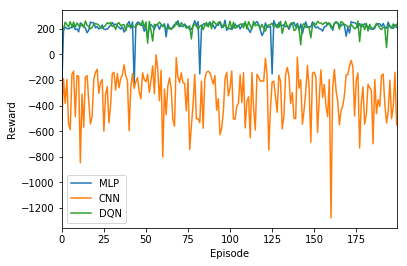

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

states_df = pd.read_csv('./lunarlander_ml_states_rewards.csv', header=None)
images_df = pd.read_csv('./lunarlander_ml_images_rewards.csv', header=None)
rl_df = pd.read_csv('./lunarlander_rl_rewards.csv', header=None)

df = pd.DataFrame()
df['MLP'] = states_df[0]
df['CNN'] = images_df[0]
df['DQN'] = rl_df[0]
ax = df.plot(kind='line')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')

In [4]:
print('MLP mean reward: {}'.format(df['MLP'].mean()))
print('CNN mean reward: {}'.format(df['CNN'].mean()))
print('DQN mean reward: {}'.format(df['DQN'].mean()))

MLP mean reward: 210.77166447499542
CNN mean reward: -315.6527262444425
DQN mean reward: 220.92534500000002


In [8]:
print('MLP Solved episodes: {}'.format(df.loc[df['MLP'] > 200]['MLP'].count()))
print('CNN Solved episodes: {}'.format(df.loc[df['CNN'] > 200]['CNN'].count()))
print('DQN Solved episodes: {}'.format(df.loc[df['DQN'] > 200]['DQN'].count()))

MLP Solved episodes: 156
CNN Solved episodes: 0
DQN Solved episodes: 173


In [9]:
print('MLP Negative episodes: {}'.format(df.loc[df['MLP'] < 0]['MLP'].count()))
print('CNN Negative episodes: {}'.format(df.loc[df['CNN'] < 0]['CNN'].count()))
print('DQN Negative episodes: {}'.format(df.loc[df['DQN'] < 0]['DQN'].count()))

MLP Negative episodes: 4
CNN Negative episodes: 200
DQN Negative episodes: 0


# Evaluation

Using the 3-step evaluation strategy described in the previous question (visual, accuracy, solved episodes), we evaluated the models like so.

Visually, both the DQN and MLP looked to perform very well. DQN appeared to have less slip ups. CNN however, performed dreadfully, at times looking as if the actions it took were completely random.

In terms of accuracy, the DQN model performed best, which was expected. Interestingly, the slim difference between it and the MLP was mostly due to it crashing the spacecraft now and then (it had 4 episodes resulting in negative rewards), highlighted by the sharp troughs in the line graph above. We believe that the difference between the two models would further increase if the DQN was trained for more episodes. The CNN performed much worse than the other two models (all 200 of its episodes resulted in negative rewards). In fact, there was a difference of over 500 in the rewards of CNN and MLP/DQN.

DQN had almost 20 more solved episodes than MLP, while CNN solved 0 episodes.

In terms of computation time required to train each model, we found DQN to be relatively quick, MLP to be a little bit slower, and CNN to be quite a lot slower. This leads us to believe that CNN would require a very large amount of training to be effective at this task.

Taking both accuracy and computation time into account, we believe that the DQN model is most suited to this task, especially if computation resources are limited. Over the 200 episodes, it consistently performed well and didn't take too long to train. MLP also performed well, however, the fact that it crashed 4 times shows us that it is less consistent than DQN. We believe the poor performance of the CNN is most likely due us using greyscale images whilst training it, as opposed to using multiple channels to represent the RGB values. We did this to reduce computational constraints. Also, we only trained the CNN model on a limited number of images, again, due to computational restraints.